In [ ]:
!pip install -Uqq fastbook ipywidgets nbdev

import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# your drive home will be at /content/gdrive/MyDrive/
# your notebooks might be at /content/gdrive/MyDrive/Colab Notebooks/
BASE_DIR = "/content/gdrive/MyDrive/Colab Notebooks/fastai_book"
# BASE_DIR = "./work"

# https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk
# torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

path = untar_data(URLs.MNIST_SAMPLE, data=f"{BASE_DIR}/data")

def filesToStackedTensors(d1, d2):
  t = [tensor(Image.open(f)).to(device) for f in (path/d1/d2).ls().sorted()]
  return torch.stack(t).float()/255

def x_y(stacked_x, stacked_y):
  x = torch.cat([stacked_x, stacked_y]).view(-1, 28*28)
  y = tensor([1]*len(stacked_x) + [0]*len(stacked_y)).unsqueeze(1).to(device)
  return (x, y)

train_x, train_y = x_y(filesToStackedTensors('train', '3'), \
                       filesToStackedTensors('train', '7'))
valid_x, valid_y = x_y(filesToStackedTensors('valid', '3'), \
                       filesToStackedTensors('valid', '7'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# how does multiplication work with tensors
a1 = tensor([1, 2, 3])
b1 = tensor([4, 4, 4])
print(f'b.T: {b1.T}, a1 * b1.T: {a1 * b1.T}')
b2 = tensor([[4],[4],[4]])
print(f'b.T: {b2.T}, a1 * b2.T: {a1 * b2.T}')

a2 = tensor([[1,2,3]])
a3 = tensor([[[1,2,3]]])
print(f'a2 * b2.T: {a2 * b2.T}')
print(f'a3 * b2.T: {a3 * b2.T}')

# can't multiply if sizes don't match
# b3 = tensor([1,2,3,4])
# a1 * b3, a1 * b3.T

b.T: tensor([4, 4, 4]), a1 * b1.T: tensor([ 4,  8, 12])
b.T: tensor([[4, 4, 4]]), a1 * b2.T: tensor([[ 4,  8, 12]])
a2 * b2.T: tensor([[ 4,  8, 12]])
a3 * b2.T: tensor([[[ 4,  8, 12]]])


<ipython-input-2-cecdd65296a8>:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  print(f'b.T: {b1.T}, a1 * b1.T: {a1 * b1.T}')


In [ ]:
def init_params(size, std=1.0): return (torch.randn(size) * std).to(device).requires_grad_()
weights = init_params((28*28, 1))
print(f'weights.shape: {weights.shape}')
print(f'weights[0:3]: {weights[0:3]}')
bias = init_params(1)
print(f'bias: {bias}')

# x = train_x[0].unsqueeze(0)
print(f'train_x len: {len(train_x)}')
print(f'train_x shape: {train_x.shape}')
print(f'train_x[0] shape: {train_x[0].shape}')
print(f'train_x[0][0:3] shape: {train_x[0][0:3]}')
prediction = (train_x[0]*weights.T).sum() + bias
print(f'prediction for first image: {prediction}')
prediction = (train_x[0]*(weights * 1.0001).T).sum() + bias
print(f'prediction for first image: {prediction}')
prediction = (train_x[0]*(weights*0.9999).T).sum() + bias
print(f'prediction for first image: {prediction}')

weights.shape: torch.Size([784, 1])
weights[0:3]: tensor([[ 1.7062],
        [ 1.1659],
        [-0.2401]], grad_fn=<SliceBackward0>)
bias: tensor([-0.2762], requires_grad=True)
train_x len: 12396
train_x shape: torch.Size([12396, 784])
train_x[0] shape: torch.Size([784])
train_x[0][0:3] shape: tensor([0., 0., 0.])
prediction for first image: tensor([3.8255], grad_fn=<AddBackward0>)
prediction for first image: tensor([3.8259], grad_fn=<AddBackward0>)
prediction for first image: tensor([3.8251], grad_fn=<AddBackward0>)


In [ ]:
import time

def linear1(x, w, b): return x@w + b
s1 = time.time()
preds1 = linear1(train_x, weights, bias)
print(f'time taken using linear1: {time.time() - s1}')
print(f'preds1.shape: {preds1.shape}')

def linear2(x, w, b):
  preds = torch.zeros((len(x), 1))
  for i in range(len(x)):
    preds[i] = ((x[i]*w.T).sum() + bias)
  return preds

# s2 = time.time()
# preds2 = linear2(train_x, weights, bias)
# print(f'time taken using linear2: {time.time() - s2}')
# print(f'preds2.shape: {preds2.shape}')

a1 = ((preds1>0).float() == train_y).float().mean()
# a2 = ((preds2>0).float() == train_y).float().mean()
print(f'a1: {a1}')

def loss(preds, y):
  s = preds.sigmoid()
  return torch.where((y == 1), 1-s, s).float().mean()

loss(preds1, train_y)

time taken using linear1: 0.008666038513183594
preds1.shape: torch.Size([12396, 1])
a1: 0.5996289253234863


tensor(0.4075, grad_fn=<MeanBackward0>)

In [ ]:
# what is the effect of making small changes to weights on the predictions

preds3 = linear1(train_x, weights*1.2, bias)
a3 = ((preds3>0).float() == train_y).float().mean()
preds4 = linear1(train_x, weights*0.8, bias)
a4 = ((preds4>0).float() == train_y).float().mean()
a1, a3, a4

(tensor(0.5380), tensor(0.5380), tensor(0.5384))

In [ ]:
# gradient descent that works on entire data set per epoch

def gradient_descent(x, y, w, b):
  l = 0
  lr = 1
  for i in range(100):
    p = linear1(x, w, b)
    l = loss(p, y)
    l.backward()
    w.data = w.data - w.grad * lr
    b.data = b.data - b.grad * lr
    w.grad = b.grad = None

  return l, w, b

l, w, b = gradient_descent(train_x, train_y, weights, bias)
print(f'final loss: {l}')

final loss: 0.055593740195035934


In [ ]:
# How Dataloader works
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
print(f'list(dl): {list(dl)}')
for x in dl:
  print(f'len: {len(dl)}')

list(dl): [tensor([ 3, 12,  8, 10,  2]), tensor([ 9,  4,  7, 14,  5]), tensor([ 1, 13,  0,  6, 11])]
len: 3
len: 3
len: 3


In [ ]:
#??zip
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y
len(dset), type(dset), type(dset[0]), type(dset[0][0]), len(dset[0][0]), type(dset[0][1])
valid_dset = list(zip(valid_x, valid_y))

In [ ]:
# analyse accuracy

# a = ((linear1(train_x, w, b) > 0.5).float() == train_y).float().mean()

def batch_accuracy(xb, yb, w, b):
  p = linear1(xb, w, b)
  return ((p > 0.5).float() == yb).float().mean()

a1 = batch_accuracy(train_x, train_y, w, b)
print(f'training set accuracy: {a1}')

a2 = batch_accuracy(valid_x, valid_y, w, b)
print(f'validation set accuracy: {a2}')

def batch_accuracy_dl(dset, w, b):
  accs = [batch_accuracy(xb, yb, w, b) for xb, yb in dset]
  return torch.stack(accs).mean()

print(f'accuracy using batches from dset: {batch_accuracy_dl(dset, w, b)}')

training set accuracy: 0.9495804905891418
validation set accuracy: 0.9494602680206299
accuracy using batches from dset: 0.9495804905891418


In [ ]:
# gradient descent that works on a batch of data per epoch

def gradient_descent_dl(dl, model, weights, bias):
  l = 0
  lr = 1
  for x, y in dl:
    p = model(x, weights, bias)
    l = loss(p, y)
    l.backward()
    weights.data = weights.data - weights.grad.data
    bias.data = bias.data - bias.grad.data
    weights.grad = bias.grad = None
  return l, weights, bias

dl = DataLoader(dset, batch_size=255, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=255, shuffle=True)

gradient_descent_dl(dl, linear1, weights, bias)[0]

tensor(0.0492, grad_fn=<MeanBackward0>)

In [ ]:
# Rewrite above functionality using an optimizer object and model from pytorch library

# Basic optimiser class
class BasicOptimiser:
  def __init__(self, params, lr):
    self.params = list(params)
    self.lr = lr

  def step(self):
    for p in self.params:
      p.data = p.data - p.grad.data * self.lr

  def zero_grad(self):
    for p in self.params:
      p.grad = None

# training function
def train_epoch(dl, model, opt):
  for xb, yb in dl:
    p = model(xb)
    l = loss(p, yb)
    l.backward()
    opt.step()
    opt.zero_grad()

# # define accuracy again without w & b params as they're built into the model now
def batch_accuracy2(xb, yb, model):
  p = model(xb)
  return ((p > 0.5).float() == yb).float().mean()

def batch_accuracy_dl2(dl, model):
  accs = [batch_accuracy2(xb, yb, model) for xb, yb in dl]
  return torch.stack(accs).mean()

In [55]:
# create the model
linear_pyt = nn.Linear(28*28, 1)
w, b = linear_pyt.parameters()
print(f'w.shape: {w.shape}, b.shape: {b.shape}')

# Create the optimiser
lr = 1.
opt = BasicOptimiser(linear_pyt.parameters(), lr)

# analyse accuracy
print(f'acc before training: {batch_accuracy_dl2(dl, linear_pyt)}')
train_epoch(dl, linear_pyt, opt)
# batch_accuracy_dl2(dl, linear2)
print(f'acc after one epoch: {batch_accuracy_dl2(dl, linear_pyt)}')

def train_model(dl, model, opt, n, pr=False):
  for i in range(n):
    train_epoch(dl, model, opt)
    if pr:
      print(f'acc after {i} epochs: {batch_accuracy_dl2(dl, model)}')

train_model(dl, linear_pyt, opt, 10, pr=True)
print(f'validation accuracy: {batch_accuracy_dl2(valid_dl, linear_pyt)}')

w.shape: torch.Size([1, 784]), b.shape: torch.Size([1])
acc before training: 0.5057915449142456
acc after one epoch: 0.9779988527297974
acc after 0 epochs: 0.9811493158340454
acc after 1 epochs: 0.9811493754386902
acc after 2 epochs: 0.9838412404060364
acc after 3 epochs: 0.9831209778785706
acc after 4 epochs: 0.9837320446968079
acc after 5 epochs: 0.984794020652771
acc after 6 epochs: 0.984401524066925
acc after 7 epochs: 0.9858929514884949
acc after 8 epochs: 0.9858128428459167
acc after 9 epochs: 0.9862930178642273
validation accuracy: 0.9803766012191772


validation accuracy: 0.98087078332901


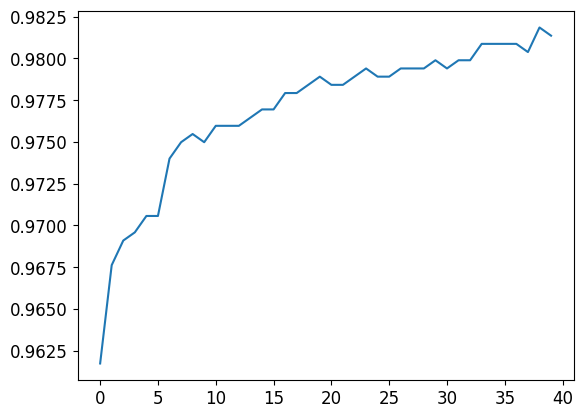

In [65]:
# use pytorch and fastai functions: nn.Linear is model & parameters, SGD is BasicOptimiser, Learner is train_model
lr = 1.
linear_pyt = nn.Linear(28*28, 1)
opt = SGD(linear_pyt.parameters(), lr)
train_model(dl, linear_pyt, opt, 10)
print(f'validation accuracy: {batch_accuracy_dl2(valid_dl, linear_pyt)}')

# define accuracy again without model param, xb is supposed to be the output of model() without sigmoid function applied
def batch_accuracy3(xb, yb):
  p = xb.sigmoid()
  return ((p > 0.5).float() == yb).float().mean()

dls = DataLoaders(dl, valid_dl)
#learner = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=loss, metrics=batch_accuracy3)
#learner.fit(10, lr=lr)

simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

learner = Learner(dls, simple_net, opt_func=SGD, loss_func=loss, metrics=batch_accuracy3)
with learner.no_logging():
  learner.fit(40, 0.1)
plt.plot(L(learner.recorder.values).itemgot(2))

In [66]:
dls = ImageDataLoaders.from_folder(path)
learner = vision_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)
learner.fit_one_cycle(1, 0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.078232,0.011756,0.996565,03:54
